<>:147: SyntaxWarning: invalid escape sequence '\s'
<>:147: SyntaxWarning: invalid escape sequence '\s'
/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_2096/1832261913.py:147: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"$\sigma$ = {std}")
/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_2096/1832261913.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')                # choose 'tab10' or 'tab20'


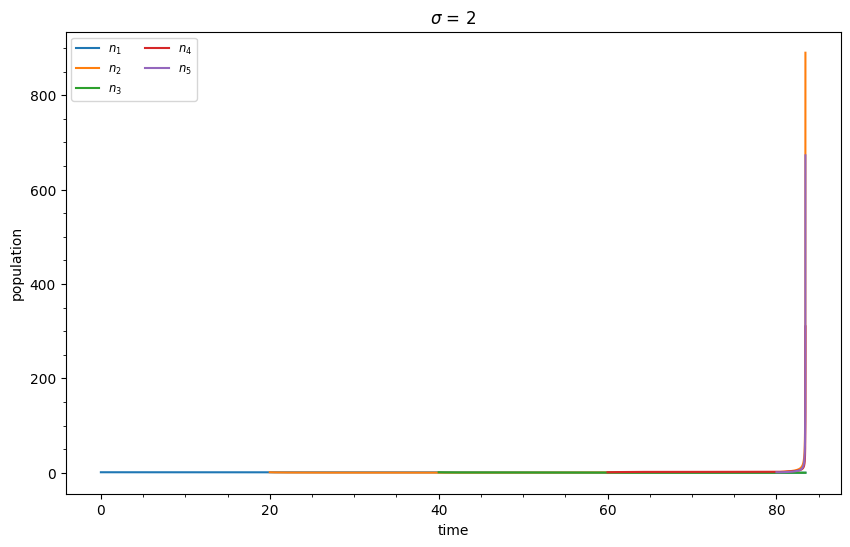

[-1.22270924e-10  1.94193405e+05 -2.72668239e-20  6.33991375e+04
  1.47949322e+05]


np.float64(267434.20908526465)

In [150]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm

def A_matrix_calculator(matrix_parameters):
    N, s, sigma, gamma, seed = matrix_parameters
    if not (-1.0 <= gamma <= 1.0):
        raise ValueError("gamma must lie in [-1, 1] for a valid covariance matrix.")

    rng = np.random.default_rng(seed)
    mu = s / N
    var = sigma**2 / N
    cov = gamma * var

    covmat = np.array([[var, cov],
                       [cov, var]])

    S = np.empty((N, N), dtype=float)
    S[np.diag_indices(N)] =  1

    iu, ju = np.triu_indices(N, k=1)
    m = len(iu)
    if m > 0:
        draws = rng.multivariate_normal(mean=[mu, mu], cov=covmat, size=m)
        S[iu, ju] = draws[:, 0]
        S[ju, iu] = draws[:, 1]
    # print(S)
    return S

def dndt(t, n_arr, r, k, migration, A_matrix):
    current_N = n_arr.size
    A_sub = A_matrix[:current_N, :current_N]
    interaction_terms = A_sub.dot(n_arr)
    # n_dot_arr = (r / k) * (k * n_arr - n_arr**2) - interaction_terms * n_arr + migration
    n_dot_arr = n_arr * (r - interaction_terms) + migration
    return n_dot_arr

def solver(current_N, t_span, t_eval, sigma, n_i_0, A_matrix, r=1.0, k=1.0, migration=1.0):
    args = (r, k, migration, A_matrix)
    sol = solve_ivp(fun=lambda t, y: dndt(t, y, *args),
                    t_span=t_span,
                    y0=np.asarray(n_i_0, dtype=float),
                    # method = 'DOP853',
                    t_eval=t_eval,
                    vectorized=False)
    return sol

import numpy as np

def order_parameter_calculator(N_total, std, plot):
    cmap = cm.get_cmap('tab10')                # choose 'tab10' or 'tab20'
    def color_for_species(idx):
        return cmap(idx % cmap.N)
    global_time = []
    global_populations = None   # will be (n_time, species_count)
    plotted = []

    dt = 0.01
    time_per_block = 20
    sigma = std

    initial_species_value = 1
    time_interval_array = np.linspace(0, time_per_block*N_total, N_total + 1)

    r = 1.0; k = 1.0; migration = 0; s = 1.0; gamma = 0.5; seed = 423132

    matrix_parameters = (N_total, s, sigma, gamma, seed)
    A_full = A_matrix_calculator(matrix_parameters)

    addition_times = []
    snapshots = []
    sol = None

    for i in range(len(time_interval_array) - 1):
        current_N = i + 1      
        t0 = time_interval_array[i]
        t1 = time_interval_array[i + 1]
        t_eval = np.arange(t0, t1, dt)

        if i == 0:
            n0 = np.full(current_N, initial_species_value, dtype=float)
        else:
            prev_last = sol.y[:, -1]
            addition_times.append(t0)
            n0 = np.append(prev_last, initial_species_value)

        # Pass the same A_full to solver; dndt will use the top-left current_N x current_N block.
        sol = solver(current_N, 
                     t_span=(t0, t1), 
                     t_eval=t_eval, 
                     sigma=sigma, 
                     n_i_0=n0, 
                     A_matrix=A_full, 
                     r=r, k=k, 
                     migration=migration)

        snapshots.append(sol.y[:, -1].copy())

        if global_populations is None:
            global_sim_time = sol.t.copy()
            global_populations = sol.y.T.copy()
        else:
            global_sim_time = np.concatenate([global_sim_time, sol.t])
            prev_cols = global_populations.shape[1]
            if current_N > prev_cols:
                global_populations = np.hstack([global_populations, np.full((global_populations.shape[0], current_N - prev_cols), np.nan)])
            block_rows = sol.y.T
            if block_rows.shape[1] < global_populations.shape[1]:
                block_rows = np.hstack([block_rows, np.full((block_rows.shape[0], global_populations.shape[1] - block_rows.shape[1]), np.nan)])
            global_populations = np.vstack([global_populations, block_rows])

    if plot:
        plt.figure(figsize=(10, 6))
        num_species_reached = global_populations.shape[1]
        for sidx in range(num_species_reached):
            color = color_for_species(sidx)
            label = f"$n_{sidx+1}$" if sidx not in plotted else None
            plt.plot(global_sim_time, global_populations[:, sidx], color=color, label=label)
            plotted.append(sidx)
    
    # final_species = []
    # for i in global_populations[:, sidx]:
        # Find indices of species whose final population is zero
        # tolerance = 1e-5

        # indices = np.where(np.isclose(global_populations[-1, :], 0, atol=tolerance))[0]

        # r_array = np.ones(N_total)
        # A_reduced = np.delete(A_full, indices, axis=0)  # remove row k
        # A_reduced = np.delete(A_reduced, indices, axis=1)  # remove column k
        # r_reduced = np.delete(r_array, indices)  # remove the known entry

        # # Solve for the reduced x
        # sol_reduced = np.linalg.solve(A_reduced, r_reduced)

        # # Only insert zeros at valid positions
        # valid_indices = indices[indices <= sol_reduced.size]
        # sol = np.insert(sol_reduced, valid_indices, 0)

        # # print(x)
        # for i in sol:
        #     plt.hlines(i, time_interval_array[0], time_interval_array[-1], colors='k', linestyles='dashed')

        plt.xlabel('time')
        plt.ylabel('population')
        plt.title(f"$\sigma$ = {std}")
        plt.minorticks_on()
        plt.legend(ncol=2, fontsize='small')
        plt.show()

    # print(global_populations[:, sidx][-1])
    # final_populations = []
    # for i in global_populations[:, sidx]:
    #     final_populations.append(i[-1])
    # print(final_populations)

    # extracting a convenient form of the species snapshots so that I can compute the order parameter
    max_len = max(len(s) for s in snapshots)
    n_events = len(snapshots)
    species_snapshots = np.full((n_events, max_len), np.nan, dtype=float)
    for i, s in enumerate(snapshots):
        species_snapshots[i, :len(s)] = s

    species_arrays = [species_snapshots[:, j].copy() for j in range(max_len)]
    species_arrays = [i[~np.isnan(i)] for i in species_arrays]
    species_arrays = np.array([np.insert(arr, 0, initial_species_value) for arr in species_arrays], dtype=object)
    # print(species_arrays)
    final_elements = [arr[-1] for arr in species_arrays]
    # print(final_elements)
    sol = dndt(np.linspace(55, 60), np.asarray(final_elements), 1, 1, 0, A_full)
    print(sol)
    order_parameter = np.mean([sum((x[i+1] - x[i])**2 for i in range(len(x)-1)) for x in species_arrays])
    return order_parameter


N_total = 5; sigma = 2

order_parameter_calculator(N_total, sigma, plot = True)


In [90]:
s = 1.0; gamma = 0.5; seed = 423132

matrix_parameters = (N_total, s, sigma, gamma, seed)
A_full = A_matrix_calculator(matrix_parameters)
r_array = np.ones(N_total)


A_reduced = np.delete(A_full, [0, 4], axis=0)  # remove row k
A_reduced = np.delete(A_reduced, [0, 4], axis=1)  # remove column k
r_reduced = np.delete(r_array, [0, 4])  # remove the known entry

# Solve for the reduced x
x_reduced = np.linalg.solve(A_reduced, r_reduced)

# Insert the known zero back into solution
x = np.insert(x_reduced, [0, 4], 0)

print(x)

[[ 1.          0.20559558  0.35017671  0.92423369  0.46087621  0.0679357 ]
 [ 0.50936493  1.          0.11983219 -0.69648959  0.63777801  0.20102869]
 [ 0.43687894 -0.36983997  1.          0.31605971  1.04606887  0.27978779]
 [-0.04432037 -0.54660238  0.54827559  1.          0.28356246 -0.00345387]
 [-0.51601425  0.21569913  0.66576221  1.1053446   1.          0.1045643 ]
 [ 0.11589992 -0.06833352  0.25450483 -0.62004787  0.38599136  1.        ]]
[0.         1.6591042  0.5531134  1.6104198  1.97113976 0.        ]


In [ ]:
import numpy as np

A = np.array([[3, 1, 2],
              [1, 4, 1],
              [0, 2, 3]])
b = np.array([10, 12, 8])

# Suppose we know x[1] = 0 (second entry)


# Remove column k from A
A_reduced = np.delete(A, k, axis=1)

# Solve for the reduced x
x_reduced = np.linalg.solve(A_reduced, b)

# Insert the known zero back into solution
x = np.insert(x_reduced, k, 0)

print("Solution with x[1] = 0:", x)


31110.427736148817


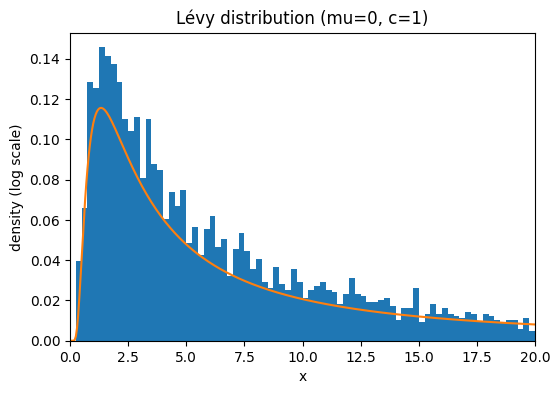

In [68]:
import numpy as np
from scipy.stats import levy

# parameters
mu = 0.0      # location
c = 4.0       # scale
n = 5000

rng = np.random.default_rng(123)
samples = levy.rvs(loc=mu, scale=c, size=n, random_state=rng)
# quick check
# print(samples[:10])
plt.figure(figsize=(6,4))
plt.hist(samples, bins=200, range=(0,50), density=True)
x = np.linspace(0.001, 50, 1000)
plt.plot(x, levy.pdf(x, loc=mu, scale=c))
plt.xlim(0, 50)
# plt.yscale('log')   # log-scale often helps for heavy tails
plt.xlabel('x')
plt.ylabel('density (log scale)')
plt.title('Lévy distribution (mu=0, c=1)')
plt.xlim(0, 20)
plt.show()